# III - Scoring the Trained Model

Once the model is trained on Azure Batch Shipyard, it can be retrieved from blob storage and used to score unseen data
* [Setup](#section1)
* [Downloading the trained model](#section2)
* [Loading the trained model in memory](#section3)
* [Scoring unseen images](#section4)
* [Test with your own image](#section5)
* [Scoring at scale on Batch Shipyard](#section6)

## Setup

Install the tqdm progress bar utility

In [1]:
!pip install tqdm

Create alias for shipyard

In [2]:
%alias shipyard SHIPYARD_CONFIGDIR=config python $HOME/batch-shipyard/shipyard.py %l

Check that everything is working

In [3]:
shipyard

Usage: shipyard.py [OPTIONS] COMMAND [ARGS]...

  Batch Shipyard: Provision and Execute Docker Workloads on Azure Batch

Options:
  --version   Show the version and exit.
  -h, --help  Show this message and exit.

Commands:
  cert      Certificate actions
  data      Data actions
  fs        Filesystem in Azure actions
  jobs      Jobs actions
  keyvault  KeyVault actions
  misc      Miscellaneous actions
  pool      Pool actions
  storage   Storage actions


Imports, configuration and constants

In [4]:
%matplotlib inline

import random
import json
from math import sqrt
import cntk
import os
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from tqdm import tqdm
import xml
import pickle

HTML("""<style>.output_png {display: table-cell;text-align: right;vertical-align: middle;}</style>""")

# Downloading assets
MODEL = 'ConvNet_CIFAR10_model.dnn'
MODEL_FOLDER = 'models'
IMAGE_FOLDER = 'images'
MODEL_PATH = os.path.join(MODEL_FOLDER, MODEL)

# Assets for scoring on the notebook
LOCAL_MEAN_FILE = 'mean.xml'
LOCAL_TEST_BATCH = 'test_batch.pickle'
URL_FMT = 'https://batchshipyardexamples.blob.core.windows.net/scoring/{}'

MEAN_IMAGE_URI = URL_FMT.format(LOCAL_MEAN_FILE)
TEST_BATCH_URI = URL_FMT.format(LOCAL_TEST_BATCH)

# Loading the configuration from setup notebook
CONFIG_FILE = 'account_information.json'
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)
    
STORAGE_ACCOUNT_NAME = config['storage_account_name']
STORAGE_ACCOUNT_KEY = config['storage_account_key']
IMAGE_NAME = config['IMAGE_NAME']
STORAGE_ALIAS = config['STORAGE_ALIAS']

# Utility function
def write_json_to_file(json_dict, filename):
    """ Simple function to write JSON dictionaries to files
    """
    with open(filename, 'w') as outfile:
        json.dump(json_dict, outfile)

/home/nbuser/anaconda2_410/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
# Creating the folder for the trained models
!rm -rf $MODEL_FOLDER $IMAGE_FOLDER
!mkdir -p $MODEL_FOLDER
!mkdir -p $IMAGE_FOLDER

## Downloading the trained model
The model we trained in the previous notebook can be downloaded from blob storage. First, let's alias `blobxfer` to simplify transfers rather than using the Azure CLI.

In [6]:
%alias blobxfer python -m blobxfer

We will attempt to download the model from the storage account. `blobxfer` will complete successfully with exit code of 0 if the model exists.

In [7]:
blobxfer $STORAGE_ACCOUNT_NAME output $MODEL_FOLDER --remoteresource . --include "*_cntk-training-job/*.dnn" --download --storageaccountkey $STORAGE_ACCOUNT_KEY

 azure blobxfer parameters [v0.12.1]
             platform: Linux-4.4.0-75-generic-x86_64-with-debian-stretch-sid
   python interpreter: CPython 2.7.11
     package versions: az.common=1.1.5 az.sml=0.20.5 az.stor=0.34.2 crypt=1.9 req=2.18.1
      subscription id: None
      management cert: None
   transfer direction: Azure->local
       local resource: models
      include pattern: *_cntk-training-job/*.dnn
      remote resource: .
   max num of workers: 24
              timeout: None
      storage account: batcha3dc41fdst
              use SAS: False
  upload as page blob: False
  auto vhd->page blob: False
 upload to file share: False
 container/share name: output
  container/share URI: https://batcha3dc41fdst.blob.core.windows.net/output
    compute block MD5: False
     compute file MD5: True
    skip on MD5 match: True
   chunk size (bytes): 4194304
     create container: True
  keep mismatched MD5: False
     recursive if dir: True
component strip on up: 1
        remote delete:

In [8]:
print("Downloaded model from prior notebook training run")
!mv $MODEL_FOLDER/*_cntk-training-job/*.dnn $MODEL_FOLDER
!rm -rf $MODEL_FOLDER/*_cntk-training-job

Downloaded model from prior notebook training run


The model has been downloaded on the environment of the notebook and is ready to use

In [9]:
!ls -alF $MODEL_FOLDER

total 4700
drwxr-xr-x  2 nbuser nbuser    4096 Jun 21 15:01 ./
drwx------ 18 nbuser nbuser    4096 Jun 21 15:00 ../
-rw-r--r--  1 nbuser nbuser 4802199 Jun 21 15:01 ConvNet_CIFAR10_model.dnn


## Loading the trained model in memory

The model is expecting CIFAR-10 type images, i.e. RGB images with dimensions 32x32

In [10]:
# model dimensions
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 10
# Class labels in order
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
model = cntk.load_model(MODEL_PATH)

## Scoring unseen images

We download some unseen test data

In [12]:
!wget $MEAN_IMAGE_URI -O $LOCAL_MEAN_FILE
!wget $TEST_BATCH_URI -O $LOCAL_TEST_BATCH

--2017-06-21 15:02:08--  https://batchshipyardexamples.blob.core.windows.net/scoring/mean.xml
Resolving webproxy (webproxy)... 100.112.194.116
Connecting to webproxy (webproxy)|100.112.194.116|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 40183 (39K) [application/xml]
Saving to: 'mean.xml'

mean.xml            100%[===================>]  39.24K  --.-KB/s    in 0s      

2017-06-21 15:02:08 (188 MB/s) - 'mean.xml' saved [40183/40183]

--2017-06-21 15:02:08--  https://batchshipyardexamples.blob.core.windows.net/scoring/test_batch.pickle
Resolving webproxy (webproxy)... 100.112.194.116
Connecting to webproxy (webproxy)|100.112.194.116|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 31035526 (30M) [application/octet-stream]
Saving to: 'test_batch.pickle'

test_batch.pickle   100%[===================>]  29.60M  46.5MB/s    in 0.6s    

2017-06-21 15:02:09 (46.5 MB/s) - 'test_batch.pickle' saved [31035526/31035526]



Process the mean image, as a pre-processing step applied to the images to score

In [13]:
mean_image = xml.etree.ElementTree.parse(LOCAL_MEAN_FILE).getroot()
mean_image = [float(i) for i in mean_image.find('MeanImg').find('data').text.strip().split(' ')]
mean_image = np.array(mean_image).reshape((32, 32, 3)).transpose((2, 0, 1))

Utility functions to help loading and scoring images

In [14]:
def load_image(filepath):
    """ 
    Loading the image and resizing it to match
    the expected format from the network
    """
    img = Image.open(filepath)
    img.load()
    wpercent = (IMAGE_WIDTH/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((IMAGE_WIDTH,hsize), Image.ANTIALIAS)
    return img

def get_predicted_label(model, img, mean_image): 
    """ 
    Perform a forward pass on the network
    and return the predicted label
    """
    # Convert image to array
    img = np.asarray(img, dtype="float32")
    # Add padding to be 32x32
    img = np.lib.pad(img, ((IMAGE_WIDTH-img.shape[0],0),(IMAGE_HEIGHT-img.shape[1],0),(0,0)), 'constant', constant_values=(0))
    # Transpose from 32x32x3 to 3x32x32
    img = np.transpose(img, (2, 0, 1))
    img -= mean_image
    
    # Forward pass
    out = model.forward(img)
    
    # Getting the predicted label
    predictions = out[1].values()[0][0]
    selected_label = LABELS[predictions.argmax()]
    return selected_label

Loading 10000 unseen images from a pickled file

In [15]:
def reshape_image(record):
    image, label, filename = record
    return image.reshape(3,32,32).transpose(1,2,0), label, filename

In [16]:
with open(LOCAL_TEST_BATCH, 'r') as f:
    test_batch = pickle.load(f)
records = zip(test_batch['data'], test_batch['labels'], test_batch['filenames'])
records = map(reshape_image, records)

Scoring the images in turn and displaying the results

/home/nbuser/anaconda2_410/lib/python2.7/site-packages/cntk/core.py:74: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


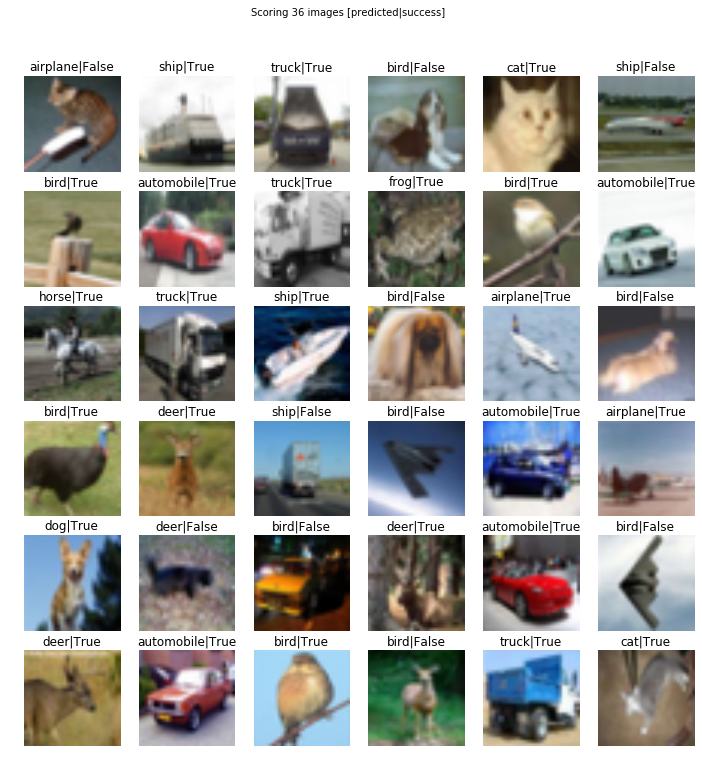

In [17]:
m = 6

# Creating a grid of m by m plots
f, axarr = plt.subplots(m, m)
f.set_size_inches(m*2, m*2)
f.suptitle("Scoring {} images [predicted|success]".format(m*m))

# Scoring each image and plotting it in the grid
# with the label as a title
random.shuffle(records)
for i in range(m):
    for j in range(m):
        img = records[i*m+j][0]
        label = get_predicted_label(model, img, mean_image)
        axarr[i, j].set_title("{}|{}".format(label, label==LABELS[records[i*m+j][1]]))
        axarr[i, j].axis('off')
        axarr[i, j].imshow(img)

## Test with your own image

Upload an image, of one of the 10 labels, using the `Data` > `Upload...` menu in the tool bar

In [18]:
image_name = "<YOUR_IMAGE_NAME.PNG>"

Process the image

In [19]:
img = load_image(image_name)
label = get_predicted_label(model, img, mean_image)

IOError: [Errno 2] No such file or directory: '<YOUR_IMAGE_NAME.PNG>'

Display the result

In [20]:
img = Image.open(image_name)
img.load()
f = plt.figure()
plt.imshow(img)
plt.title(label)
plt.axis("off")

IOError: [Errno 2] No such file or directory: '<YOUR_IMAGE_NAME.PNG>'

## Scoring at scale on Batch Shipyard

Running locally on the notebook

In [21]:
result = []
for record in tqdm(records):
    label = get_predicted_label(model, record[0], mean_image)
    result.append(label)

100%|██████████| 10000/10000 [01:16<00:00, 130.13it/s]


It is pretty fast... can we do better on Batch Shipyard?

Let's first write a driver file that will perform the scoring and upload everything we need on our storage account

In [22]:
%%writefile score.py
import os
import json
import cntk
import numpy as np 
import xml
import pickle
import time

tic = time.time()

# model dimensions
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 10

MODEL_PATH = 'ConvNet_CIFAR10_model.dnn'
LOCAL_MEAN_FILE = 'mean.xml'
LOCAL_TEST_BATCH = 'test_batch.pickle'

def reshape_image(record):
    image, label, filename = record
    return image.reshape(3,32,32).transpose(1,2,0), label, filename

def get_predicted_label(model, img, mean_image): 
    """ 
    Perform a forward pass on the network
    and return the predicted label
    """
    # Convert image to array
    img = np.asarray(img, dtype="float32")
    # Add padding to be 32x32
    img = np.lib.pad(img, ((IMAGE_WIDTH-img.shape[0],0),(IMAGE_HEIGHT-img.shape[1],0),(0,0)), 'constant', constant_values=(0))
    # Transpose from 32x32x3 to 3x32x32
    img = np.transpose(img, (2, 0, 1))
    img -= mean_image
    
    # Forward pass
    out = model.forward(img)
    
    # Getting the predicted label
    predictions = list(out[1].values())[0][0]
    return predictions.argmax()


# Loading the model
model = cntk.load_model(MODEL_PATH)

# Loading the mean image
mean_image = xml.etree.ElementTree.parse(LOCAL_MEAN_FILE).getroot()
mean_image = [float(i) for i in mean_image.find('MeanImg').find('data').text.strip().split(' ')]
mean_image = np.array(mean_image).reshape((32, 32, 3)).transpose((2, 0, 1))

# Loading the images
with open(LOCAL_TEST_BATCH, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    test_batch = u.load()
records = zip(test_batch['data'], test_batch['labels'], test_batch['filenames'])
records = map(reshape_image, records)

result = []
i = 0
for record in records:
    if i % 1000 == 0:
        print("processed {} records".format(i))
    i+=1
    label = get_predicted_label(model, record[0], mean_image)
    # convert label type numpy.int64 to python int
    result.append((label.item(), record[1], record[2]))

toc = time.time()
print("{} seconds elapsed to process {} records".format(toc-tic, i))

with open('results.json', 'w') as f:
    json.dump(result, f)

Writing score.py


Let's upload all of the data we need to ingress in the batch task:
- the mean file
- the image data file
- the trained model
- the python driver, score.py

Let's designate the containers to use for input and output and then copy all of the input data into one directory to upload via blobxfer to the `INPUT_CONTAINER`:

In [23]:
INPUT_CONTAINER = "inputscore"
OUTPUT_CONTAINER = "outputscore"

UPLOAD_DIR = 'score_upload'

!mkdir -p $UPLOAD_DIR
!cp $LOCAL_TEST_BATCH $LOCAL_MEAN_FILE $MODEL_PATH score.py $UPLOAD_DIR
!ls -alF $UPLOAD_DIR

total 35056
drwxr-xr-x  2 nbuser nbuser     4096 Jun 21 15:06 ./
drwx------ 19 nbuser nbuser     4096 Jun 21 15:06 ../
-rw-r--r--  1 nbuser nbuser  4802199 Jun 21 15:06 ConvNet_CIFAR10_model.dnn
-rw-r--r--  1 nbuser nbuser    40183 Jun 21 15:06 mean.xml
-rw-r--r--  1 nbuser nbuser     2113 Jun 21 15:06 score.py
-rw-r--r--  1 nbuser nbuser 31035526 Jun 21 15:06 test_batch.pickle


Upload via `blobxfer` to the `INPUT_CONTAINER`:

In [24]:
blobxfer $STORAGE_ACCOUNT_NAME $INPUT_CONTAINER $UPLOAD_DIR --upload --storageaccountkey $STORAGE_ACCOUNT_KEY

 azure blobxfer parameters [v0.12.1]
             platform: Linux-4.4.0-75-generic-x86_64-with-debian-stretch-sid
   python interpreter: CPython 2.7.11
     package versions: az.common=1.1.5 az.sml=0.20.5 az.stor=0.34.2 crypt=1.9 req=2.18.1
      subscription id: None
      management cert: None
   transfer direction: local->Azure
       local resource: score_upload
      include pattern: None
      remote resource: None
   max num of workers: 24
              timeout: None
      storage account: batcha3dc41fdst
              use SAS: False
  upload as page blob: False
  auto vhd->page blob: False
 upload to file share: False
 container/share name: inputscore
  container/share URI: https://batcha3dc41fdst.blob.core.windows.net/inputscore
    compute block MD5: False
     compute file MD5: True
    skip on MD5 match: True
   chunk size (bytes): 4194304
     create container: True
  keep mismatched MD5: False
     recursive if dir: True
component strip on up: 1
        remote delete: Fal

Now let's create the jobs json specification. The task will first activate cntk and then run the scoring script.

In [27]:
JOB_ID = 'cntk-scoring-job'

COMMAND = 'bash -c "source /cntk/activate-cntk; python -u score.py"'

jobs = {
    "job_specifications": [
        {
            "id": JOB_ID,
            "tasks": [
                {
                    "image": IMAGE_NAME,
                    "remove_container_after_exit": True,
                    "command": COMMAND,
                    "gpu": True,
                    "output_data": {
                        "azure_storage": [
                            {
                                "storage_account_settings": STORAGE_ALIAS,
                                "container": OUTPUT_CONTAINER,
                                "include": ["*.json"],
                                "blobxfer_extra_options": "--delete --strip-components 2"
                            }
                        ]
                    },
                    "input_data": {
                        "azure_storage": [
                            {
                                "storage_account_settings": STORAGE_ALIAS,
                                "container": INPUT_CONTAINER
                            }
                        ]
                    },
                }
            ],
        }
    ]
}

In [28]:
write_json_to_file(jobs, os.path.join('config', 'jobs.json'))
print(json.dumps(jobs, indent=4, sort_keys=True))

{
    "job_specifications": [
        {
            "id": "cntk-scoring-job", 
            "tasks": [
                {
                    "command": "bash -c \"source /cntk/activate-cntk; python -u score.py\"", 
                    "gpu": true, 
                    "image": "microsoft/cntk:2.0-gpu-python3.5-cuda8.0-cudnn5.1", 
                    "input_data": {
                        "azure_storage": [
                            {
                                "container": "inputscore", 
                                "storage_account_settings": "mystorageaccount"
                            }
                        ]
                    }, 
                    "output_data": {
                        "azure_storage": [
                            {
                                "blobxfer_extra_options": "--delete --strip-components 2", 
                                "container": "outputscore", 
                                "include": [
                                 

Now that the specification for the jobs is written, we add the task to batch shipyard

In [29]:
shipyard jobs add --tail stdout.txt

2017-06-21 15:07:24,664 INFO - Adding job cntk-scoring-job to pool gpupool
2017-06-21 15:07:25,456 INFO - uploading file /tmp/tmpaMZqD7 as u'shipyardtaskrf-cntk-scoring-job/dockertask-00000.shipyard.envlist'
2017-06-21 15:07:25,727 DEBUG - submitting 1 tasks (0 -> 0) to job cntk-scoring-job
2017-06-21 15:07:25,954 INFO - submitted all 1 tasks to job cntk-scoring-job
2017-06-21 15:07:25,954 DEBUG - attempting to stream file stdout.txt from job=cntk-scoring-job task=dockertask-00000
 azure blobxfer parameters [v0.12.1]
             platform: Linux-4.4.0-81-generic-x86_64-with
   python interpreter: CPython 3.5.2
     package versions: az.common=1.1.4 az.sml=0.20.5 az.stor=0.33.0 crypt=1.6 req=2.12.3
      subscription id: None
      management cert: None
   transfer direction: Azure->local
       local resource: .
      include pattern: None
      remote resource: .
   max num of workers: 18
              timeout: None
      storage account: batcha3dc41fdst
              use SAS: True
  

We can see the total duration of the time taken for the task with the command:

In [30]:
shipyard jobs listtasks --jobid $JOB_ID

2017-06-21 15:08:13,706 INFO - job_id=cntk-scoring-job task_id=dockertask-00000 [state=TaskState.completed max_retries=0 retention_time=10675199 days, 2:48:05.477581 pool_id=gpupool node_id=tvm-4283973576_1-20170621t143056z start_time=2017-06-21 15:07:26.181049+00:00 end_time=2017-06-21 15:07:44.609003+00:00 duration=0:00:18.427954 exit_code=0]


We can retrieve the results from the executed task from the `OUTPUT_CONTAINER`:

In [31]:
blobxfer $STORAGE_ACCOUNT_NAME $OUTPUT_CONTAINER $MODEL_FOLDER --download --remoteresource results.json --storageaccountkey $STORAGE_ACCOUNT_KEY

 azure blobxfer parameters [v0.12.1]
             platform: Linux-4.4.0-75-generic-x86_64-with-debian-stretch-sid
   python interpreter: CPython 2.7.11
     package versions: az.common=1.1.5 az.sml=0.20.5 az.stor=0.34.2 crypt=1.9 req=2.18.1
      subscription id: None
      management cert: None
   transfer direction: Azure->local
       local resource: models
      include pattern: None
      remote resource: results.json
   max num of workers: 24
              timeout: None
      storage account: batcha3dc41fdst
              use SAS: False
  upload as page blob: False
  auto vhd->page blob: False
 upload to file share: False
 container/share name: outputscore
  container/share URI: https://batcha3dc41fdst.blob.core.windows.net/outputscore
    compute block MD5: False
     compute file MD5: True
    skip on MD5 match: True
   chunk size (bytes): 4194304
     create container: True
  keep mismatched MD5: False
     recursive if dir: True
component strip on up: 1
        remote delete:

In [32]:
!ls -alF $MODEL_FOLDER

total 5040
drwxr-xr-x  2 nbuser nbuser    4096 Jun 21 15:08 ./
drwx------ 19 nbuser nbuser    4096 Jun 21 15:06 ../
-rw-r--r--  1 nbuser nbuser 4802199 Jun 21 15:01 ConvNet_CIFAR10_model.dnn
-rw-r--r--  1 nbuser nbuser  345995 Jun 21 15:08 results.json


**Note:** we could have used the `shipyard data getfile` command to retrieve the `results.json` file directly from the compute node if we did not need to persist the results to Azure Storage and the compute node is still running.

Now that we are done with the scoring job, delete it:

In [33]:
shipyard jobs del -y --termtasks --wait

2017-06-21 15:08:39,885 INFO - Deleting job: cntk-scoring-job
2017-06-21 15:08:39,885 DEBUG - disabling job cntk-scoring-job first due to task termination
2017-06-21 15:08:40,781 DEBUG - Skipping termination of completed task dockertask-00000 on job cntk-scoring-job
2017-06-21 15:08:41,174 DEBUG - waiting for job cntk-scoring-job to delete
2017-06-21 15:09:13,432 INFO - job cntk-scoring-job does not exist


[Next notebook: Parametric Sweep](04_Parameter_Sweep.ipynb)